In [15]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns

import os
import itertools

import warnings
warnings.filterwarnings('ignore')

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD

# Вспомогательные функции

In [36]:
col_groups = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'Class']


def plot_barh_func(df, bar=True):
    for i in list(df):
        plt.figure()
        plt.title(i)
        if bar == True:
            df[i].value_counts().plot.barh(figsize=(8, 6))
        else:
            df[i].plot.hist(bins=300, figsize=(8, 6))
        plt.show()
        
        
def get_group(df, column_name):
    return df[df.columns[df.columns.str.contains(column_name)]]


def complement_col_func(df, col_list):
    compl_list = list(set(list(df)) - (set(list(df)) & set(col_list)))
    return compl_list


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def fill_med(df, col_name):
    median = df[col_name].median()
    df[col_name].fillna(median, inplace=True)

# Загружаем датасет и делаем первичный анализ

In [3]:
df = pd.read_csv('thyroid.csv', sep = ', ')
df.shape

C:\Users\Maria\Anaconda3a\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


(7200, 22)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 22 columns):
Age                          7200 non-null float64
Sex                          7200 non-null int64
On_thyroxine                 7200 non-null int64
Query_on_thyroxine           7200 non-null int64
On_antithyroid_medication    7200 non-null int64
Sick                         7200 non-null int64
Pregnant                     7200 non-null int64
Thyroid_surgery              7200 non-null int64
I131_treatment               7200 non-null int64
Query_hypothyroid            7200 non-null int64
Query_hyperthyroid           7200 non-null int64
Lithium                      7200 non-null int64
Goitre                       7200 non-null int64
Tumor                        7200 non-null int64
Hypopituitary                7200 non-null int64
Psych                        7200 non-null int64
TSH                          7200 non-null float64
T3                           7200 non-null float64
TT4  

In [166]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,7200.0,0.520518,0.189269,0.0100,0.37000,0.5500,0.6700,0.970
Sex,7200.0,0.304306,0.460145,0.0000,0.00000,0.0000,1.0000,1.000
On_thyroxine,7200.0,0.130556,0.336937,0.0000,0.00000,0.0000,0.0000,1.000
Query_on_thyroxine,7200.0,0.015417,0.123212,0.0000,0.00000,0.0000,0.0000,1.000
On_antithyroid_medication,7200.0,0.012778,0.112322,0.0000,0.00000,0.0000,0.0000,1.000
Sick,7200.0,0.038333,0.192013,0.0000,0.00000,0.0000,0.0000,1.000
Pregnant,7200.0,0.010833,0.103525,0.0000,0.00000,0.0000,0.0000,1.000
Thyroid_surgery,7200.0,0.014028,0.117613,0.0000,0.00000,0.0000,0.0000,1.000
I131_treatment,7200.0,0.016806,0.128551,0.0000,0.00000,0.0000,0.0000,1.000
Query_hypothyroid,7200.0,0.065556,0.247521,0.0000,0.00000,0.0000,0.0000,1.000


In [158]:
df['Class'].value_counts()
# Результат говорит о том, что датасет несбалансирован, преобладает класс №3

3    6666
2     368
1     166
Name: Class, dtype: int64

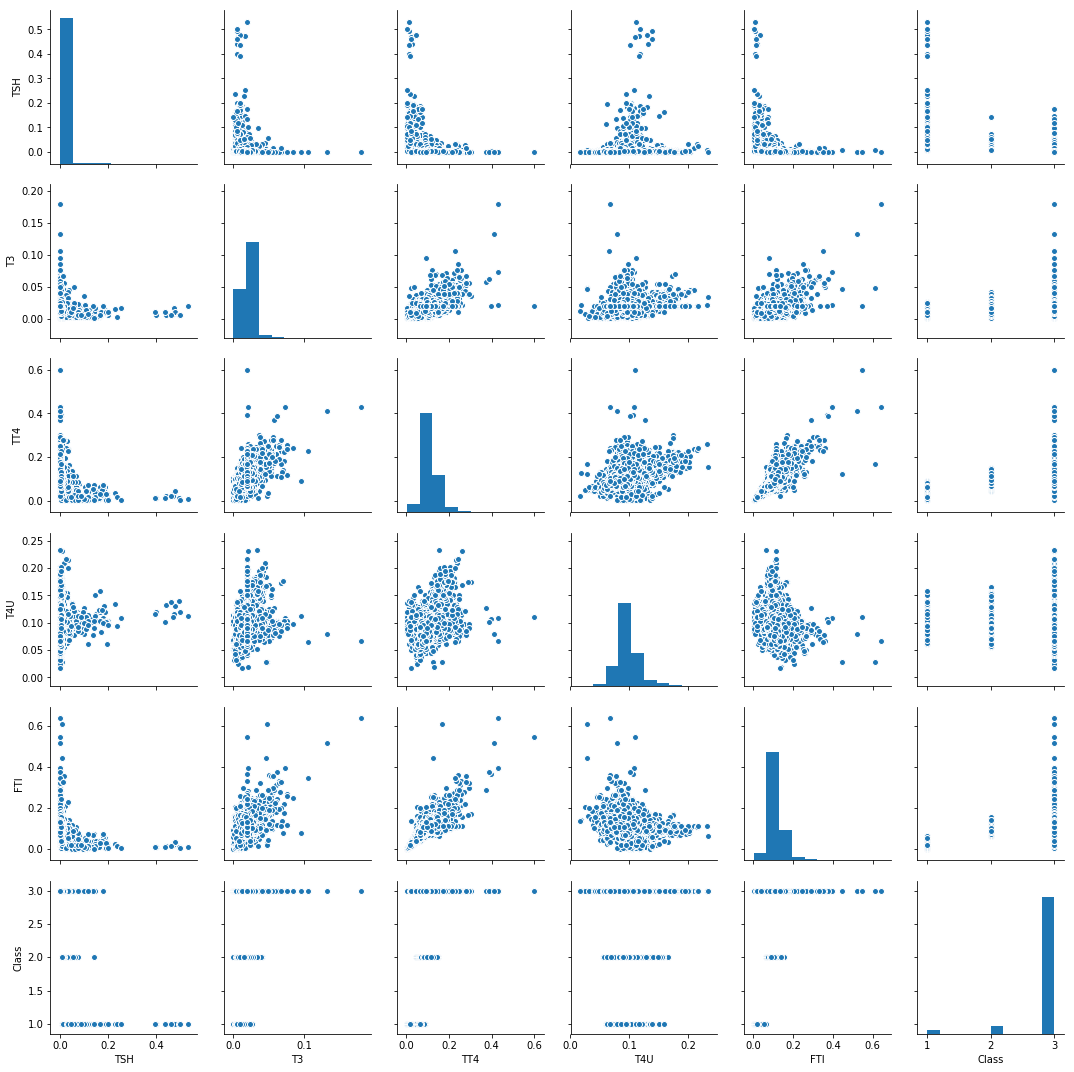

In [67]:
sns.pairplot(df[['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'Class']])
# Как следует из графиков, в классе 1 содержатся больные с гипотиреозом, 
# класс 2 - это здоровые, класс 3 - больные с гипертиреозом

# Наибольшие отличия между классами характерны для показателя FTI, 
# наибольшее отличие больных гипотиреозом от других групп - по показателю TSH

In [159]:
# Смотрим, как отличаются значения остальных показателей (кроме гормонов) в разных классах
pd.pivot_table(df, values=['Age', 'Sex', 'On_thyroxine', 'Query_on_thyroxine', 
                           'On_antithyroid_medication', 'Sick', 'Pregnant', 
                           'Thyroid_surgery', 'I131_treatment', 'Query_hypothyroid', 
                           'Query_hyperthyroid', 'Lithium', 'Goitre', 'Tumor', 
                           'Hypopituitary', 'Psych'], index = 'Class').T

Class,1,2,3
Age,0.535783,0.553560,0.518314
Goitre,0.000000,0.000000,0.008851
Hypopituitary,0.000000,0.000000,0.000150
I131_treatment,0.036145,0.016304,0.016352
Lithium,0.000000,0.016304,0.012751
On_antithyroid_medication,0.006024,0.008152,0.013201
On_thyroxine,0.102410,0.000000,0.138464
Pregnant,0.000000,0.000000,0.011701
Psych,0.006024,0.027174,0.051155
Query_hyperthyroid,0.048193,0.065217,0.069457


In [162]:
# Анализ показал, что:
# 1. Показатель I131_treatment (прием препаратов йода) встречается с 
# практически одинаковой частотой у больных гипертиреозом и здоровых.
# 2. В связи с неравным количеством пациентов в разных классах, беременные 
# встречаются только среди больных гипертиреозом
# 3. Частота пациентов с опухолями практически одинкова во всех классах

In [160]:
# Рассмотрим, как отличается уровень гормонов у беременных пациенток
pd.pivot_table(df, values=['TSH', 'T3', 'TT4', 'T4U', 'FTI'], index = 'Pregnant').T

Pregnant,0,1
FTI,0.113304,0.105091
T3,0.019874,0.029319
T4U,0.097284,0.148397
TSH,0.004903,0.001020
TT4,0.108948,0.153425


In [320]:
# Рассмотрим, как отличается уровень гормонов у пациентов с опухолями и без них
pd.pivot_table(df, values=['TSH', 'T3', 'TT4', 'T4U', 'FTI'], 
               index = ['Class', 'Tumor']).T

Class         1                  2                   3          
Tumor         0        1         0         1         0         1
FTI    0.032023  0.04550  0.097225  0.080291  0.116063  0.118723
T3     0.009380  0.02075  0.017161  0.021375  0.020288  0.023998
T4U    0.102914  0.11425  0.097708  0.103625  0.097484  0.106041
TSH    0.097798  0.03375  0.013683  0.014462  0.002117  0.001362
TT4    0.032160  0.05225  0.094269  0.082750  0.111896  0.123422

In [321]:
# Рассмотрим, как отличается уровень гормонов у пациентов, принимающих препарат йода и нет
pd.pivot_table(df, values=['TSH', 'T3', 'TT4', 'T4U', 'FTI'], 
               index = ['Class', 'I131_treatment']).T

Class                  1                   2                   3          
I131_treatment         0         1         0         1         0         1
FTI             0.032929  0.016833  0.097031  0.086333  0.116156  0.114657
T3              0.009616  0.010667  0.017207  0.020033  0.020376  0.020872
T4U             0.103144  0.104333  0.097597  0.112333  0.097675  0.099477
TSH             0.097258  0.069500  0.013751  0.010583  0.002075  0.003465
TT4             0.033247  0.016583  0.093988  0.095833  0.112201  0.111727

# Готовим датасеты к классификации

## Вводим дополнительные переменные

In [24]:
df['FTI2'] = df['FTI'] ** -1
df['T32'] = df['T3'] ** -1
df['TSH_FTI'] = (df['FTI'] ** -1) * (df['TSH'] * 10)

## Разбиваем датасет

In [25]:
y = df['Class']
X = df.drop(['Class', 'I131_treatment', 'Pregnant'], axis = 1)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(ratio = 'majority', random_state = 0)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

In [17]:
X_resampled.shape

(467, 22)

# Создаем модель на основе логистической регрессии

In [28]:
my_scorer = make_scorer(f1_score, average = 'macro')
skv = StratifiedKFold(5)

In [29]:
tuned_parameters = [{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 1e4, 1e6]}]

clf = GridSearchCV(LogisticRegression(random_state=17),
                   tuned_parameters,
                   scoring = my_scorer,
                   cv = skv, verbose = 2, n_jobs = -1)

clf.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    3.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 10000.0, 1000000.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score, average=macro), verbose=2)

In [30]:
clf.best_estimator_

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [31]:
clf = LogisticRegression(
    C=10000.0,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    max_iter=100,
    multi_class='ovr',
    n_jobs=1,
    penalty='l2',
    random_state=17,
    solver='liblinear',
    tol=0.0001,
    verbose=0,
    warm_start=False)
clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

In [32]:
y_true, y_pred = y_test, clf.predict(X_test.values)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          1       0.79      0.87      0.83        55
          2       0.60      1.00      0.75       123
          3       1.00      0.96      0.98      1982

avg / total       0.97      0.96      0.96      2160



In [33]:
f1_score(y_test, y_pred, average = 'weighted')

0.96054086730141408

In [34]:
class_names =range(1, 4)

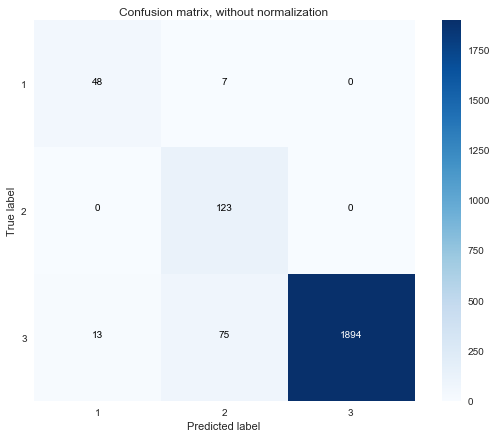

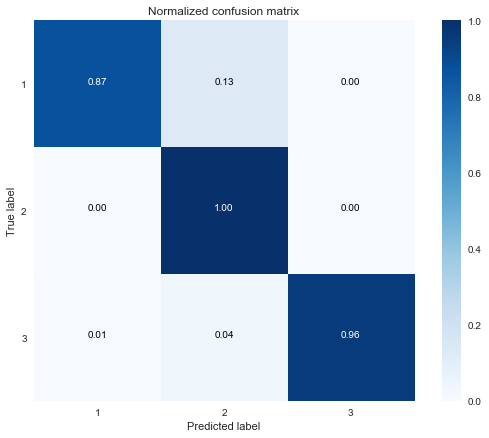

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision = 2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (8, 6))
plot_confusion_matrix(cnf_matrix, classes = class_names,
                      title = 'Confusion matrix, without normalization')
plt.savefig("ConMatrix.png")

# Plot normalized confusion matrix
plt.figure(figsize = (8, 6))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=True,
                      title = 'Normalized confusion matrix')

plt.show()
plt.savefig("ConMatrixNorm.png")